# Example case study code for using Bayesian analysis and model averaging to derive frequency-magnitude relationships for volcanoes in Southeast Asia

## Background
Determining the relationship between frequency and magnitude of volcanism is an important element of long-term volcanic hazard risk assessment. However, there is substantial uncertainty when estimating potential future eruption frequency and style, particularly in regions where eruption history data are relatively poorly constrained. To derive frequency-magnitude relationships in such environments, previous approaches have used analogues, typically defined as a function of the volcano morphology. 

Southeast Asia is a particularly active volcanic region, with over 170 volcanoes considered active in the Holocene. This high density of potentially active volcanoes coupled with relatively high population density means that Southeast Asia is one of the highest volcanic risk regions in the world (Loughlin et al. 2015). However, the volcanic record in the region is relatively limited (Simkin and Siebert 1994). Consequently, there is considerable uncertainty associated with the frequency-magnitude of volcanic eruptions at volcanoes in the region (Jenkins et al. 2012; Mead and Magill 2014; Whelley et al. 2015). 

Bayesian analysis has been utilised as a method for assessing frequency-magnitude relationships for volcanoes (e.g. Sheldrake 2014; Sheldrake and Carricchi 2017). However, such approaches are still sensitive to the choice of prior used in the Bayesian update. Ensemble modelling, where multiple different models are combined to produce a single forecast, has been put forward as a useful approach in such situations. 

In this notebook, we present an example case study to derive frequency-magnitude relationships for volcanoes in Southeast Asia. The proposed approach uses a Bayesian updating method and integrates different models for classifying analogues using model averaging.

**A note for the reader:** To provide a logical structure to the intuition behind the approach, the code differs subtly from that presented within the actual code used to conduct the analysis, but it is functionally identical. 

## Necessary libraries

Below are the required libraries to run this notebook. Numpy, Pandas, SciPy, and Matplotlib are typical python packages and their documentation can be consulted for further information. Below, we discuss PyMC3, the probabilistic programming package used in this work for Bayesian analysis.

### Summary of PyMC3
Numerous probabilistic programming languages and systems have been developed in the last few decades. We use PyMC3 probabilistic programming package (Salvatier et al. 2016) for python to conduct Bayesian analysis. The benefit of using PyMC3 is that it is open-source and provides a simple and intuitive integration into the python programming language, offering flexibility for interacting with existing python code (Salvatier et al. 2016).

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-darkgrid'])
from scipy import stats
from pymc3 import Model, Normal, Uniform, Beta, Dirichlet, Multinomial, Binomial

## Using analogues to assess frequency-magnitudes of volcanic eruptions in Southeast Asia

Since Southeast Asia has numerous volcanoes with poor eruption records, but are considered to be potentially active, there is a need to find a transparent and robust methodologies to assess how likely these volcanoes are to eruption for volcanic hazard assessment. Analogue volcanoes are typically used to assess frequency-magnitude relationships for volcanoes with poor eruption records, under the assumption that volcanoes will behave similarly to selected analogues (e.g. Jenkins et al. 2012; Whelley et al. 2015; Sheldrake 2014). Often volcano morphology (e.g. large cone, caldera) is used to define different volcano analogue classifications. However, there is no standardised approach to selecting volcano analogues. For example, Jenkins et al. (2012) utilised the Primary Volcano Type classification from the GVP, whereas Whelley et al. (2015) used a desktop geomorphological investigation using remotely sensed imagery and consideration of the recent activity at the volcano (e.g. gas emissions and recent eruptive behaviour) to classify analogues. These two different approaches to analogue classification can result in different estimates for frequency-magnitude at volcanoes.

Below, we use the Jenkins et al. (2012) and Whelley et al. (2015) approaches to selecting analogues as they are the two approaches that have been applied specifically to Southeast Asia. 

## Model 1: Jenkins approach to global analogue frequency-magnitude

Jenkins et al. (2012) developed a methodology to estimate average recurrence intervals for eruptions greater than or equal to
Volcanic Explosivity Index (VEI) 4. The methodology uses the eruption history of each volcano and, for data poor volcanoes, the globally averaged eruptive behaviour of analogous volcanoes.

To infer averaged eruptive behaviour across analogous volcanoes, Jenkins et al. (2012) used the Smithsonian Institution classification of volcanoes from the Global Volcanism Program (GVP) volcano database and assigned each volcano to a broad type category (see below table taken from Jenkins et al. 2012 - Table 4). Jenkins et al. (2012) then used the GVP database to determine conditional magnitude probabilities for VEI 4, 5, 6 and 7 relative to eruptions VEI 3 and below, for each volcano category. The globally averaged eruption conditional probabilities were then applied to each volcano of the same category. 

| Volcano type category | Smithsonian Institution definition |
| --- | --- |
| Caldera | Caldera, Calderas, pyroclastic shield |
| Large cone | Complex volcano, Complex volcanoes, Compound volcanoes, Somma volcano, Stratovolcano, Stratovolcanoes, Volcanic complex |
| Shield | Shield volcano, Shield volcanoes |
| Lava dome | Lava dome, Lava domes |
| Small cone | Cinder cone, Cinder cones, Cones, Crater rows, Explosion craters, Fissure vent, Fissure vents, Lava cone, Maar, Maars, Pyroclastic cone, Pyroclastic cones, Scoria cones, Tuff cones, Tuff rings, Volcanic field |

Note: The GVP definitions have changed slightly since the publication of Jenkins et al. (2012) and we have adjusted accordingly (see code below).

This section of code does the following:
1. Combines the GVP eruption database and the GVP holocene volcano list to obtain a dataframe containing the necessary information.
2. Re-classifies the GVP volcano type to be consistent with the classification framework presented in Jenkins et al. (2012). 
3. The count of confirmed eruptions at different VEI for different volcano classifications is there determined.
4. Probabilities for each VEI (conditional on an eruption) are then determined for each volcano type. The purpose of this is to use these values as analogues probabilities for each volcano type. 
5. A csv file can then be saved for future reference. 

In [2]:
# Model 1: Jenkins Global Analogue

GVP_df = pd.read_csv("GVP_DB_2019.csv") #GVP eruption data
GVP_volcanoes = pd.read_csv("Volcano_list.csv") #GVP Holocene volcanoes list

# Just formatting the resulting dataframe
GVP_df2 = GVP_df[['Volcano Number', 'Volcano Name', 'Eruption Category', 'VEI', 'Start Year', 'Start Year Uncertainty']].copy()
GVP_df2a = pd.merge(GVP_df2, GVP_volcanoes, on=['Volcano Number'], how='left')
GVP_df3 = GVP_df2a[['Volcano Number', 'Volcano Name_x', 'Eruption Category', 'Primary Volcano Type', 'VEI', 'Start Year', 'Start Year Uncertainty', 'Region', 'Country', 'Subregion']].copy()


# Assigning eruption analogue classification

# Caldera
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Caldera', 'Volcano type'] = 'Caldera' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] =='Calderas', 'Volcano type'] = 'Caldera' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Pyroclastic shield', 'Volcano type'] = 'Caldera'
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Caldera(s)', 'Volcano type'] = 'Caldera' 

# Large cone
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Stratovolcano', 'Volcano type'] = 'Large cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Complex', 'Volcano type'] = 'Large cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Stratovolcano(es)', 'Volcano type'] = 'Large cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Compound', 'Volcano type'] = 'Large cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Stratovolcano?', 'Volcano type'] = 'Large cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Complex(es)', 'Volcano type'] = 'Large cone'  

# Shield
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Shield', 'Volcano type'] = 'Shield' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Shield(s)', 'Volcano type'] = 'Shield' 

# Lava dome
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Lava dome(s)', 'Volcano type'] = 'Lava dome' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Lava dome', 'Volcano type'] = 'Lava dome' 

# Small cone
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Pyroclastic cone(s)', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Pyroclastic cone', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Lava cone', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Explosion crater(s)', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Fissure vent(s)', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Volcanic field', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Maar(s)', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Cone(s)', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Fissure vent', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Crater rows', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Maar', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Tuff cone(s)', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Lava cone(s)', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Tuff cone', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Tuff ring(s)', 'Volcano type'] = 'Small cone' 
GVP_df3.loc[GVP_df3['Primary Volcano Type'] == 'Lava cone(es)', 'Volcano type'] = 'Small cone' 

# This code counts the number of eruptioms of eaveh VEI for each analogue classification
Jenkins_VEI_all = GVP_df3[(GVP_df3['Eruption Category'] == 'Confirmed Eruption')].groupby('Volcano type').count()
Jenkins_VEI_Less_than_3 = GVP_df3[(GVP_df3.VEI <= 3) & (GVP_df3['Eruption Category']=="Confirmed Eruption")].groupby('Volcano type').count()
Jenkins_VEI_4 = GVP_df3[(GVP_df3.VEI == 4) & (GVP_df3['Eruption Category']=="Confirmed Eruption")].groupby('Volcano type').count()
Jenkins_VEI_5 = GVP_df3[(GVP_df3.VEI == 5) & (GVP_df3['Eruption Category']=="Confirmed Eruption")].groupby('Volcano type').count()
Jenkins_VEI_6 = GVP_df3[(GVP_df3.VEI == 6) & (GVP_df3['Eruption Category']=="Confirmed Eruption")].groupby('Volcano type').count()
Jenkins_VEI_7 = GVP_df3[(GVP_df3.VEI == 7) & (GVP_df3['Eruption Category']=="Confirmed Eruption")].groupby('Volcano type').count()

# Transforming the data
Jenkins_VEI_Less_than_3_df = pd.DataFrame(Jenkins_VEI_Less_than_3, columns = ['Volcano Number'])
Jenkins_VEI_Less_than_3_df.columns = ['VEI <= 3']
Jenkins_VEI_Less_than_3_df_T = Jenkins_VEI_Less_than_3_df.T

Jenkins_VEI_4_df = pd.DataFrame(Jenkins_VEI_4, columns = ['Volcano Number'])
Jenkins_VEI_4_df.columns = ['VEI 4']
Jenkins_VEI_4_df_T = Jenkins_VEI_4_df.T

Jenkins_VEI_5_df = pd.DataFrame(Jenkins_VEI_5, columns = ['Volcano Number'])
Jenkins_VEI_5_df.columns = ['VEI 5']
Jenkins_VEI_5_df_T = Jenkins_VEI_5_df.T

Jenkins_VEI_6_df = pd.DataFrame(Jenkins_VEI_6, columns = ['Volcano Number'])
Jenkins_VEI_6_df.columns = ['VEI 6']
Jenkins_VEI_6_df_T = Jenkins_VEI_6_df.T

Jenkins_VEI_7_df = pd.DataFrame(Jenkins_VEI_7, columns = ['Volcano Number'])
Jenkins_VEI_7_df.columns = ['VEI 7']
Jenkins_VEI_7_df_T = Jenkins_VEI_7_df.T

Jenkins_VEI_frames = [Jenkins_VEI_Less_than_3_df_T, Jenkins_VEI_4_df_T, Jenkins_VEI_5_df_T, Jenkins_VEI_6_df_T, Jenkins_VEI_7_df_T]
Jenkins_VEI_all_eruptions = pd.concat(Jenkins_VEI_frames)

Jenkins_VEI_all_eruptions.fillna(0, inplace=True)

Jenkins_VEI_all_eruptions_T = Jenkins_VEI_all_eruptions.T

Jenkins_VEI_all_eruptions_T['Total'] = Jenkins_VEI_all_eruptions_T['VEI <= 3'] + Jenkins_VEI_all_eruptions_T['VEI 4'] + Jenkins_VEI_all_eruptions_T['VEI 5'] + Jenkins_VEI_all_eruptions_T['VEI 6'] + Jenkins_VEI_all_eruptions_T['VEI 7']

Jenkins_Total_eruptions_caldera = Jenkins_VEI_all_eruptions_T.iloc[0]['Total']
Jenkins_Total_eruptions_LC = Jenkins_VEI_all_eruptions_T.iloc[1]['Total']
Jenkins_Total_eruptions_LD = Jenkins_VEI_all_eruptions_T.iloc[2]['Total']
Jenkins_Total_eruptions_Shield = Jenkins_VEI_all_eruptions_T.iloc[3]['Total']
Jenkins_Total_eruptions_SC = Jenkins_VEI_all_eruptions_T.iloc[4]['Total']

# Caldera
Jenkins_VEI_3_eruptions_caldera = Jenkins_VEI_all_eruptions_T.iloc[0]['VEI <= 3']
Jenkins_VEI_4_eruptions_caldera = Jenkins_VEI_all_eruptions_T.iloc[0]['VEI 4']
Jenkins_VEI_5_eruptions_caldera = Jenkins_VEI_all_eruptions_T.iloc[0]['VEI 5']
Jenkins_VEI_6_eruptions_caldera = Jenkins_VEI_all_eruptions_T.iloc[0]['VEI 6']
Jenkins_VEI_7_eruptions_caldera = Jenkins_VEI_all_eruptions_T.iloc[0]['VEI 7']

# Large cone
Jenkins_VEI_3_eruptions_LC = Jenkins_VEI_all_eruptions_T.iloc[1]['VEI <= 3']
Jenkins_VEI_4_eruptions_LC = Jenkins_VEI_all_eruptions_T.iloc[1]['VEI 4']
Jenkins_VEI_5_eruptions_LC = Jenkins_VEI_all_eruptions_T.iloc[1]['VEI 5']
Jenkins_VEI_6_eruptions_LC = Jenkins_VEI_all_eruptions_T.iloc[1]['VEI 6']
Jenkins_VEI_7_eruptions_LC = Jenkins_VEI_all_eruptions_T.iloc[1]['VEI 7']

# Lava dome
Jenkins_VEI_3_eruptions_LD = Jenkins_VEI_all_eruptions_T.iloc[2]['VEI <= 3']
Jenkins_VEI_4_eruptions_LD = Jenkins_VEI_all_eruptions_T.iloc[2]['VEI 4']
Jenkins_VEI_5_eruptions_LD = Jenkins_VEI_all_eruptions_T.iloc[2]['VEI 5']
Jenkins_VEI_6_eruptions_LD = Jenkins_VEI_all_eruptions_T.iloc[2]['VEI 6']
Jenkins_VEI_7_eruptions_LD = Jenkins_VEI_all_eruptions_T.iloc[2]['VEI 7']

# Shield
Jenkins_VEI_3_eruptions_Shield = Jenkins_VEI_all_eruptions_T.iloc[3]['VEI <= 3']
Jenkins_VEI_4_eruptions_Shield = Jenkins_VEI_all_eruptions_T.iloc[3]['VEI 4']
Jenkins_VEI_5_eruptions_Shield = Jenkins_VEI_all_eruptions_T.iloc[3]['VEI 5']
Jenkins_VEI_6_eruptions_Shield = Jenkins_VEI_all_eruptions_T.iloc[3]['VEI 6']
Jenkins_VEI_7_eruptions_Shield = Jenkins_VEI_all_eruptions_T.iloc[3]['VEI 7']

# Small cone
Jenkins_VEI_3_eruptions_SC = Jenkins_VEI_all_eruptions_T.iloc[4]['VEI <= 3']
Jenkins_VEI_4_eruptions_SC = Jenkins_VEI_all_eruptions_T.iloc[4]['VEI 4']
Jenkins_VEI_5_eruptions_SC = Jenkins_VEI_all_eruptions_T.iloc[4]['VEI 5']
Jenkins_VEI_6_eruptions_SC = Jenkins_VEI_all_eruptions_T.iloc[4]['VEI 6']
Jenkins_VEI_7_eruptions_SC = Jenkins_VEI_all_eruptions_T.iloc[4]['VEI 7']


# Determining conditional probabilities given an eruption of any magnitude
Jenkins_Cond_Prob_VEI_3_Caldera = Jenkins_VEI_3_eruptions_caldera / Jenkins_Total_eruptions_caldera
Jenkins_Cond_Prob_VEI_4_Caldera = Jenkins_VEI_4_eruptions_caldera / Jenkins_Total_eruptions_caldera
Jenkins_Cond_Prob_VEI_5_Caldera = Jenkins_VEI_5_eruptions_caldera / Jenkins_Total_eruptions_caldera
Jenkins_Cond_Prob_VEI_6_Caldera = Jenkins_VEI_6_eruptions_caldera / Jenkins_Total_eruptions_caldera
Jenkins_Cond_Prob_VEI_7_Caldera = Jenkins_VEI_7_eruptions_caldera / Jenkins_Total_eruptions_caldera

Jenkins_Cond_Prob_VEI_3_LC = Jenkins_VEI_3_eruptions_LC / Jenkins_Total_eruptions_LC
Jenkins_Cond_Prob_VEI_4_LC = Jenkins_VEI_4_eruptions_LC / Jenkins_Total_eruptions_LC
Jenkins_Cond_Prob_VEI_5_LC = Jenkins_VEI_5_eruptions_LC / Jenkins_Total_eruptions_LC
Jenkins_Cond_Prob_VEI_6_LC = Jenkins_VEI_6_eruptions_LC / Jenkins_Total_eruptions_LC
Jenkins_Cond_Prob_VEI_7_LC = Jenkins_VEI_7_eruptions_LC / Jenkins_Total_eruptions_LC

Jenkins_Cond_Prob_VEI_3_LD = Jenkins_VEI_3_eruptions_LD / Jenkins_Total_eruptions_LD
Jenkins_Cond_Prob_VEI_4_LD = Jenkins_VEI_4_eruptions_LD / Jenkins_Total_eruptions_LD
Jenkins_Cond_Prob_VEI_5_LD = Jenkins_VEI_5_eruptions_LD / Jenkins_Total_eruptions_LD
Jenkins_Cond_Prob_VEI_6_LD = Jenkins_VEI_6_eruptions_LD / Jenkins_Total_eruptions_LD
Jenkins_Cond_Prob_VEI_7_LD = Jenkins_VEI_7_eruptions_LD / Jenkins_Total_eruptions_LD

Jenkins_Cond_Prob_VEI_3_Shield = Jenkins_VEI_3_eruptions_Shield / Jenkins_Total_eruptions_Shield
Jenkins_Cond_Prob_VEI_4_Shield = Jenkins_VEI_4_eruptions_Shield / Jenkins_Total_eruptions_Shield
Jenkins_Cond_Prob_VEI_5_Shield = Jenkins_VEI_5_eruptions_Shield / Jenkins_Total_eruptions_Shield
Jenkins_Cond_Prob_VEI_6_Shield = Jenkins_VEI_6_eruptions_Shield / Jenkins_Total_eruptions_Shield
Jenkins_Cond_Prob_VEI_7_Shield = Jenkins_VEI_7_eruptions_Shield / Jenkins_Total_eruptions_Shield

Jenkins_Cond_Prob_VEI_3_SC = Jenkins_VEI_3_eruptions_SC / Jenkins_Total_eruptions_SC
Jenkins_Cond_Prob_VEI_4_SC = Jenkins_VEI_4_eruptions_SC / Jenkins_Total_eruptions_SC
Jenkins_Cond_Prob_VEI_5_SC = Jenkins_VEI_5_eruptions_SC / Jenkins_Total_eruptions_SC
Jenkins_Cond_Prob_VEI_6_SC = Jenkins_VEI_6_eruptions_SC / Jenkins_Total_eruptions_SC
Jenkins_Cond_Prob_VEI_7_SC = Jenkins_VEI_7_eruptions_SC / Jenkins_Total_eruptions_SC

Jenkins_Conditional_probabilities_all = pd.DataFrame(np.array([[Jenkins_Cond_Prob_VEI_3_Caldera, Jenkins_Cond_Prob_VEI_3_LC, Jenkins_Cond_Prob_VEI_3_LD, Jenkins_Cond_Prob_VEI_3_Shield, Jenkins_Cond_Prob_VEI_3_SC],
                                                               [Jenkins_Cond_Prob_VEI_4_Caldera, Jenkins_Cond_Prob_VEI_4_LC, Jenkins_Cond_Prob_VEI_4_LD, Jenkins_Cond_Prob_VEI_4_Shield, Jenkins_Cond_Prob_VEI_4_SC], 
                                                               [Jenkins_Cond_Prob_VEI_5_Caldera, Jenkins_Cond_Prob_VEI_5_LC, Jenkins_Cond_Prob_VEI_5_LD, Jenkins_Cond_Prob_VEI_5_Shield, Jenkins_Cond_Prob_VEI_5_SC], 
                                                               [Jenkins_Cond_Prob_VEI_6_Caldera, Jenkins_Cond_Prob_VEI_6_LC, Jenkins_Cond_Prob_VEI_6_LD, Jenkins_Cond_Prob_VEI_6_Shield, Jenkins_Cond_Prob_VEI_6_SC], 
                                                               [Jenkins_Cond_Prob_VEI_7_Caldera, Jenkins_Cond_Prob_VEI_7_LC, Jenkins_Cond_Prob_VEI_7_LD, Jenkins_Cond_Prob_VEI_7_Shield, Jenkins_Cond_Prob_VEI_7_SC]]),
                   columns=['Caldera', 'Large cone', 'Lava dome', 'Shield', 'Small cone'])

Jenkins_Conditional_probabilities_all.to_csv("Jenkins_conditional_probabilities_given_an_eruption_2019.csv")

print(Jenkins_Conditional_probabilities_all)

C:\Users\hayes.jlee\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:84: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



    Caldera  Large cone  Lava dome    Shield  Small cone
0  0.845519    0.903893   0.741573  0.962606     0.90991
1  0.086085    0.066391   0.146067  0.030157     0.09009
2  0.036557    0.024262   0.112360  0.003619     0.00000
3  0.027123    0.004890   0.000000  0.002413     0.00000
4  0.004717    0.000564   0.000000  0.001206     0.00000


## Model 2: Whelley approach to regional analogue frequency-magnitude

Whelley et al. (2015) classified Southeast Asian volcanoes into five groups. Instead of using the GVP classification, they developed a classification framework that integrates morphology, and where known, the eruptive history and degassing style of volcanoes in Southeast Asia (see table below adapted from Figure 2 of Whelley et al. 2015). An important distinction to keep in mind is that the Jenkins approach uses globally averaged behaviour, whilst Whelley uses only volcanoes from Southeast Asia supplemented by the inclusion of some Japanese volcanoes because of the excellent volcano record from Japan.

| Volcano type category | Definition used by Whelley et al. (2015) |
| --- | --- |
| Distributed cones and fields | Field of cinder and spatter cones |
| Large caldera | Crater larger than 5 km |
| Open-vent stratocone | stratovolcanoes that have more than two VEI 1 or 2 eruptions in past decade and average more than 8 emission events per year of 0.8 kt/day of SO2 since 1979 as tabulated by Aerocom and collected by TOMS, COSPEC, and ONEM and classified as open-vent stratocones. |
| Semi-plugged stratocone | Stratocone with a summit crater less than or equal to 2.5 km and has not erupted in the past decade or has insufficient SO2 emissions |
| Well-plugged stratocone | Stratocone with a summit crater greater than or equal to 2.5 km and has not erupted in the past decade or has insufficient SO2 emissions |

This section of code does the following:
1. Takes the supplementary electronic material file from Whelley et al. (2015) and merges this with the GVP eruption database to obtain the necessary information. 
2. The eruption count for each each category using the Whelley classification categories. 
3. A csv file can be saved for reference. 

In [3]:
# Model 2: Based upon Whelley volcano classification within SEA

Whelley = pd.read_csv("Whelley_SEA.csv")
Whelley_GVP = pd.merge(Whelley, GVP_df2, on=['Volcano Number'], how='left')
Whelley_GVP_df = Whelley_GVP[['Volcano Number', 
                   'Volcano Name_x', 
                   'Eruption Category',
                    'Whelley classification', 
                   'VEI', 
                   'Start Year', 
                   'Start Year Uncertainty']].copy()

Whelley_VEI_all = Whelley_GVP_df[(Whelley_GVP_df['Eruption Category'] == 'Confirmed Eruption')].groupby('Whelley classification').count()
Whelley_VEI_Less_than_3 = Whelley_GVP_df[(Whelley_GVP_df.VEI <= 3) & (Whelley_GVP_df['Eruption Category']=="Confirmed Eruption")].groupby('Whelley classification').count()
Whelley_VEI_4 = Whelley_GVP_df[(Whelley_GVP_df.VEI == 4) & (Whelley_GVP_df['Eruption Category']=="Confirmed Eruption")].groupby('Whelley classification').count()
Whelley_VEI_5 = Whelley_GVP_df[(Whelley_GVP_df.VEI == 5) & (Whelley_GVP_df['Eruption Category']=="Confirmed Eruption")].groupby('Whelley classification').count()
Whelley_VEI_6 = Whelley_GVP_df[(Whelley_GVP_df.VEI == 6) & (Whelley_GVP_df['Eruption Category']=="Confirmed Eruption")].groupby('Whelley classification').count()
Whelley_VEI_7 = Whelley_GVP_df[(Whelley_GVP_df.VEI == 7) & (Whelley_GVP_df['Eruption Category']=="Confirmed Eruption")].groupby('Whelley classification').count()

Whelley_VEI_Less_than_3_df = pd.DataFrame(Whelley_VEI_Less_than_3, columns = ['Volcano Number'])
Whelley_VEI_Less_than_3_df.columns = ['VEI <= 3']
Whelley_VEI_Less_than_3_df_T = Whelley_VEI_Less_than_3_df.T

Whelley_VEI_4_df = pd.DataFrame(Whelley_VEI_4, columns = ['Volcano Number'])
Whelley_VEI_4_df.columns = ['VEI 4']
Whelley_VEI_4_df_T = Whelley_VEI_4_df.T

Whelley_VEI_5_df = pd.DataFrame(Whelley_VEI_5, columns = ['Volcano Number'])
Whelley_VEI_5_df.columns = ['VEI 5']
Whelley_VEI_5_df_T = Whelley_VEI_5_df.T

Whelley_VEI_6_df = pd.DataFrame(Whelley_VEI_6, columns = ['Volcano Number'])
Whelley_VEI_6_df.columns = ['VEI 6']
Whelley_VEI_6_df_T = Whelley_VEI_6_df.T

Whelley_VEI_7_df = pd.DataFrame(Whelley_VEI_7, columns = ['Volcano Number'])
Whelley_VEI_7_df.columns = ['VEI 7']
Whelley_VEI_7_df_T = Whelley_VEI_7_df.T

Whelley_VEI_frames = [Whelley_VEI_Less_than_3_df_T, 
                      Whelley_VEI_4_df_T, 
                      Whelley_VEI_5_df_T, 
                      Whelley_VEI_6_df_T, 
                      Whelley_VEI_7_df_T]
Whelley_VEI_all_eruptions = pd.concat(Whelley_VEI_frames)

Whelley_VEI_all_eruptions.fillna(0, inplace=True)

Whelley_VEI_all_eruptions_T = Whelley_VEI_all_eruptions.T

Whelley_VEI_all_eruptions_T['Total'] = Whelley_VEI_all_eruptions_T['VEI <= 3'] + Whelley_VEI_all_eruptions_T['VEI 4'] + Whelley_VEI_all_eruptions_T['VEI 5'] + Whelley_VEI_all_eruptions_T['VEI 6'] + Whelley_VEI_all_eruptions_T['VEI 7']

Whelley_Total_eruptions_SC = Whelley_VEI_all_eruptions_T.iloc[0]['Total']
Whelley_Total_eruptions_LC = Whelley_VEI_all_eruptions_T.iloc[1]['Total']
Whelley_Total_eruptions_OS = Whelley_VEI_all_eruptions_T.iloc[2]['Total']
Whelley_Total_eruptions_SPS = Whelley_VEI_all_eruptions_T.iloc[3]['Total']
Whelley_Total_eruptions_WPS = Whelley_VEI_all_eruptions_T.iloc[4]['Total']

# Distributed cones and fields
Whelley_VEI_3_eruptions_SC = Whelley_VEI_all_eruptions_T.iloc[0]['VEI <= 3']
Whelley_VEI_4_eruptions_SC = Whelley_VEI_all_eruptions_T.iloc[0]['VEI 4']
Whelley_VEI_5_eruptions_SC = Whelley_VEI_all_eruptions_T.iloc[0]['VEI 5']
Whelley_VEI_6_eruptions_SC = Whelley_VEI_all_eruptions_T.iloc[0]['VEI 6']
Whelley_VEI_7_eruptions_SC = Whelley_VEI_all_eruptions_T.iloc[0]['VEI 7']

# Large caldera
Whelley_VEI_3_eruptions_LC = Whelley_VEI_all_eruptions_T.iloc[1]['VEI <= 3']
Whelley_VEI_4_eruptions_LC = Whelley_VEI_all_eruptions_T.iloc[1]['VEI 4']
Whelley_VEI_5_eruptions_LC = Whelley_VEI_all_eruptions_T.iloc[1]['VEI 5']
Whelley_VEI_6_eruptions_LC = Whelley_VEI_all_eruptions_T.iloc[1]['VEI 6']
Whelley_VEI_7_eruptions_LC = Whelley_VEI_all_eruptions_T.iloc[1]['VEI 7']

# Open-vent stratocone
Whelley_VEI_3_eruptions_OS = Whelley_VEI_all_eruptions_T.iloc[2]['VEI <= 3']
Whelley_VEI_4_eruptions_OS = Whelley_VEI_all_eruptions_T.iloc[2]['VEI 4']
Whelley_VEI_5_eruptions_OS = Whelley_VEI_all_eruptions_T.iloc[2]['VEI 5']
Whelley_VEI_6_eruptions_OS = Whelley_VEI_all_eruptions_T.iloc[2]['VEI 6']
Whelley_VEI_7_eruptions_OS = Whelley_VEI_all_eruptions_T.iloc[2]['VEI 7']

# Semi-plugged stratocone
Whelley_VEI_3_eruptions_SPS = Whelley_VEI_all_eruptions_T.iloc[3]['VEI <= 3']
Whelley_VEI_4_eruptions_SPS = Whelley_VEI_all_eruptions_T.iloc[3]['VEI 4']
Whelley_VEI_5_eruptions_SPS = Whelley_VEI_all_eruptions_T.iloc[3]['VEI 5']
Whelley_VEI_6_eruptions_SPS = Whelley_VEI_all_eruptions_T.iloc[3]['VEI 6']
Whelley_VEI_7_eruptions_SPS = Whelley_VEI_all_eruptions_T.iloc[3]['VEI 7']

# Well-plugged stratocone
Whelley_VEI_3_eruptions_WPS = Whelley_VEI_all_eruptions_T.iloc[4]['VEI <= 3']
Whelley_VEI_4_eruptions_WPS = Whelley_VEI_all_eruptions_T.iloc[4]['VEI 4']
Whelley_VEI_5_eruptions_WPS = Whelley_VEI_all_eruptions_T.iloc[4]['VEI 5']
Whelley_VEI_6_eruptions_WPS = Whelley_VEI_all_eruptions_T.iloc[4]['VEI 6']
Whelley_VEI_7_eruptions_WPS = Whelley_VEI_all_eruptions_T.iloc[4]['VEI 7']


# Determining conditional probabilities given an eruption of any magnitude
Whelley_Cond_Prob_VEI_3_SC = Whelley_VEI_3_eruptions_SC / Whelley_Total_eruptions_SC
Whelley_Cond_Prob_VEI_4_SC = Whelley_VEI_4_eruptions_SC / Whelley_Total_eruptions_SC
Whelley_Cond_Prob_VEI_5_SC = Whelley_VEI_5_eruptions_SC / Whelley_Total_eruptions_SC
Whelley_Cond_Prob_VEI_6_SC = Whelley_VEI_6_eruptions_SC / Whelley_Total_eruptions_SC
Whelley_Cond_Prob_VEI_7_SC = Whelley_VEI_7_eruptions_SC / Whelley_Total_eruptions_SC

Whelley_Cond_Prob_VEI_3_LC = Whelley_VEI_3_eruptions_LC / Whelley_Total_eruptions_LC
Whelley_Cond_Prob_VEI_4_LC = Whelley_VEI_4_eruptions_LC / Whelley_Total_eruptions_LC
Whelley_Cond_Prob_VEI_5_LC = Whelley_VEI_5_eruptions_LC / Whelley_Total_eruptions_LC
Whelley_Cond_Prob_VEI_6_LC = Whelley_VEI_6_eruptions_LC / Whelley_Total_eruptions_LC
Whelley_Cond_Prob_VEI_7_LC = Whelley_VEI_7_eruptions_LC / Whelley_Total_eruptions_LC

Whelley_Cond_Prob_VEI_3_OS = Whelley_VEI_3_eruptions_OS / Whelley_Total_eruptions_OS
Whelley_Cond_Prob_VEI_4_OS = Whelley_VEI_4_eruptions_OS / Whelley_Total_eruptions_OS
Whelley_Cond_Prob_VEI_5_OS = Whelley_VEI_5_eruptions_OS / Whelley_Total_eruptions_OS
Whelley_Cond_Prob_VEI_6_OS = Whelley_VEI_6_eruptions_OS / Whelley_Total_eruptions_OS
Whelley_Cond_Prob_VEI_7_OS = Whelley_VEI_7_eruptions_OS / Whelley_Total_eruptions_OS

Whelley_Cond_Prob_VEI_3_SPS = Whelley_VEI_3_eruptions_SPS / Whelley_Total_eruptions_SPS
Whelley_Cond_Prob_VEI_4_SPS = Whelley_VEI_4_eruptions_SPS / Whelley_Total_eruptions_SPS
Whelley_Cond_Prob_VEI_5_SPS = Whelley_VEI_5_eruptions_SPS / Whelley_Total_eruptions_SPS
Whelley_Cond_Prob_VEI_6_SPS = Whelley_VEI_6_eruptions_SPS / Whelley_Total_eruptions_SPS
Whelley_Cond_Prob_VEI_7_SPS = Whelley_VEI_7_eruptions_SPS / Whelley_Total_eruptions_SPS

Whelley_Cond_Prob_VEI_3_WPS = Whelley_VEI_3_eruptions_WPS / Whelley_Total_eruptions_WPS
Whelley_Cond_Prob_VEI_4_WPS = Whelley_VEI_4_eruptions_WPS / Whelley_Total_eruptions_WPS
Whelley_Cond_Prob_VEI_5_WPS = Whelley_VEI_5_eruptions_WPS / Whelley_Total_eruptions_WPS
Whelley_Cond_Prob_VEI_6_WPS = Whelley_VEI_6_eruptions_WPS / Whelley_Total_eruptions_WPS
Whelley_Cond_Prob_VEI_7_WPS = Whelley_VEI_7_eruptions_WPS / Whelley_Total_eruptions_WPS

Whelley_Conditional_probabilities_all = pd.DataFrame(np.array([[Whelley_Cond_Prob_VEI_3_SC, Whelley_Cond_Prob_VEI_3_LC, Whelley_Cond_Prob_VEI_3_OS, Whelley_Cond_Prob_VEI_3_SPS, Whelley_Cond_Prob_VEI_3_WPS],
                                                               [Whelley_Cond_Prob_VEI_4_SC, Whelley_Cond_Prob_VEI_4_LC, Whelley_Cond_Prob_VEI_4_OS, Whelley_Cond_Prob_VEI_4_SPS, Whelley_Cond_Prob_VEI_4_WPS], 
                                                               [Whelley_Cond_Prob_VEI_5_SC, Whelley_Cond_Prob_VEI_5_LC, Whelley_Cond_Prob_VEI_5_OS, Whelley_Cond_Prob_VEI_5_SPS, Whelley_Cond_Prob_VEI_5_WPS], 
                                                               [Whelley_Cond_Prob_VEI_6_SC, Whelley_Cond_Prob_VEI_6_LC, Whelley_Cond_Prob_VEI_6_OS, Whelley_Cond_Prob_VEI_6_SPS, Whelley_Cond_Prob_VEI_6_WPS], 
                                                               [Whelley_Cond_Prob_VEI_7_SC, Whelley_Cond_Prob_VEI_7_LC, Whelley_Cond_Prob_VEI_7_OS, Whelley_Cond_Prob_VEI_7_SPS, Whelley_Cond_Prob_VEI_7_WPS]]),
                   columns=['Distributed cones and fields', 
                            'Large caldera', 
                            'Open-vent stratocone', 
                            'Semi-plugged stratocone', 
                            'Well-plugged stratocone'])

Whelley_Conditional_probabilities_all.to_csv("Whelley_conditional_probabilities_given_an_eruption_2019.csv")

print(Whelley_Conditional_probabilities_all)

C:\Users\hayes.jlee\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



   Distributed cones and fields  Large caldera  Open-vent stratocone  \
0                      0.818182       0.930622              0.969636   
1                      0.181818       0.055024              0.020243   
2                      0.000000       0.002392              0.007085   
3                      0.000000       0.004785              0.002024   
4                      0.000000       0.007177              0.001012   

   Semi-plugged stratocone  Well-plugged stratocone  
0                 0.923950                 0.869048  
1                 0.063564                 0.047619  
2                 0.012486                 0.035714  
3                 0.000000                 0.047619  
4                 0.000000                 0.000000  


## Select a volcano of interest in Southeast Asia

In this notebook we wil use Merapi volcano as a case study example of how the code works. Below, the volcano number assigned to Merapi by the GVP is defined. We assign variables for the volcano name and Region (in this case it is Indonesia). We also assign thresholds dates for the volcanic record considered complete from Mead and Magill (2014) (50th percentile). Identifying the changepoint is necessary because a record that is too long may lead to an underestimation of eruption frequency and an eruption record too short eliminate valuable data (Jenkins et al. 2012; Mead and Magill 2014). These changepoints become important later in the analysis when we are assigning our likelihoods in the Bayesian update. 

In [4]:
Volcano_Number = 263250 #Merapi volcano GVP volcano number
ChangePoint = pd.read_csv("ChangePoints.csv")
ChangePoint.set_index("Region", inplace = True) 
Region = GVP_volcanoes[(GVP_volcanoes['Volcano Number'] == Volcano_Number)].iloc[0][6]
Volcano_name = GVP_volcanoes[(GVP_volcanoes['Volcano Number'] == Volcano_Number)].iloc[0][1]
Complete_record_small = ChangePoint.loc[Region, 'All eruptions']
Complete_record_large = ChangePoint.loc[Region, 'Large eruptions']
Complete_record = 2019-Complete_record_small # input the record length considered complete for all eruptions.

print("Volcano name:" + Volcano_name)
print("Region:" + Region)

Volcano name:Merapi
Region:Indonesia


## Setting analogue annual frequency of eruption 
The classifcation systems from Jenkins et al. (2012) and Whelley et al. (2015) are used to estimate the frequency of eruptions at different volcano categories. We use the entire GVP eruption database of confirmed eruptions since 1960, as this date is widely regarded as the date that the volcano record can be considered complete across all regions in the world (Simkin and Siebert 1994). We determine an average rate and standard deviation of eruptions to use as our prior in the Bayesian analysis. 

The below code does the following:
1. Determines the mean rate of eruptions at each volcano type.
2. Determines the standard deviations for rate of eruptions at each volcano type. 

The cell immediately below does this for the Jenkins et al. (2012) classification system and the following cell does this for the Whelley et al. (2015) classification system.

### Jenkins classification

In [5]:
#Caldera
Eruptions_caldera = GVP_df3[(GVP_df3['Eruption Category'] == 'Confirmed Eruption') 
                    & (GVP_df3['Volcano type'] == 'Caldera')
                    & (GVP_df3['Start Year']>1960)].groupby('Volcano Number').count()
Number_of_eruptions_caldera = Eruptions_caldera['Volcano Name_x']
Rate_of_eruptions_caldera = Number_of_eruptions_caldera / 1960
Average_rate_caldera = Rate_of_eruptions_caldera.mean()
STD_rate_caldera = Rate_of_eruptions_caldera.std()*3.09

#Large cone
Eruptions_LC = GVP_df3[(GVP_df3['Eruption Category'] == 'Confirmed Eruption') 
                    & (GVP_df3['Volcano type'] == 'Large cone')
                    & (GVP_df3['Start Year']>1960)].groupby('Volcano Number').count()
Number_of_eruptions_LC = Eruptions_LC['Volcano Name_x']
Rate_of_eruptions_LC = Number_of_eruptions_LC / 1960
Average_rate_LC = Rate_of_eruptions_LC.mean()
STD_rate_LC = Rate_of_eruptions_LC.std()*3.09

#Lava dome
Eruptions_LD = GVP_df3[(GVP_df3['Eruption Category'] == 'Confirmed Eruption') 
                    & (GVP_df3['Volcano type'] == 'Lava dome')
                    & (GVP_df3['Start Year']>1960)].groupby('Volcano Number').count()
Number_of_eruptions_LD = Eruptions_LD['Volcano Name_x']
Rate_of_eruptions_LD = Number_of_eruptions_LD / 1960
Average_rate_LD = Rate_of_eruptions_LD.mean()
STD_rate_LD = Rate_of_eruptions_LD.std()*3.09

#Shield
Eruptions_Shield = GVP_df3[(GVP_df3['Eruption Category'] == 'Confirmed Eruption') 
                    & (GVP_df3['Volcano type'] == 'Shield')
                    & (GVP_df3['Start Year']>1960)].groupby('Volcano Number').count()
Number_of_eruptions_Shield = Eruptions_Shield['Volcano Name_x']
Rate_of_eruptions_Shield = Number_of_eruptions_Shield / 1960
Average_rate_Shield = Rate_of_eruptions_Shield.mean()
STD_rate_Shield = Rate_of_eruptions_Shield.std()*3.09

#Small cone
Eruptions_SC = GVP_df3[(GVP_df3['Eruption Category'] == 'Confirmed Eruption') 
                    & (GVP_df3['Volcano type'] == 'Small cone')
                    & (GVP_df3['Start Year']>1960)].groupby('Volcano Number').count()
Number_of_eruptions_SC = Eruptions_SC['Volcano Name_x']
Rate_of_eruptions_SC = Number_of_eruptions_SC / 1960
Average_rate_SC = Rate_of_eruptions_SC.mean()
STD_rate_SC = Rate_of_eruptions_SC.std()*3.09

### Whelley classification

In [6]:
#Distributed cones and fields
Whelley_Eruptions_SC = Whelley_GVP_df[(Whelley_GVP_df['Eruption Category'] == 'Confirmed Eruption') 
                    & (Whelley_GVP_df['Whelley classification'] == 'Distributed cones and fields')
                    & (Whelley_GVP_df['Start Year']>1960)].groupby('Volcano Number').count()
Whelley_Number_of_eruptions_SC = Whelley_Eruptions_SC['Volcano Name_x']
Whelley_Rate_of_eruptions_SC = Whelley_Number_of_eruptions_SC / 1960
Whelley_Average_rate_SC = Whelley_Rate_of_eruptions_SC.mean()
Whelley_STD_rate_SC = Whelley_Rate_of_eruptions_SC.std()*3.09

#Large caldera
Whelley_Eruptions_LC = Whelley_GVP_df[(Whelley_GVP_df['Eruption Category'] == 'Confirmed Eruption') 
                    & (Whelley_GVP_df['Whelley classification'] == 'Large caldera')
                    & (Whelley_GVP_df['Start Year']>1960)].groupby('Volcano Number').count()
Whelley_Number_of_eruptions_LC = Whelley_Eruptions_LC['Volcano Name_x']
Whelley_Rate_of_eruptions_LC = Whelley_Number_of_eruptions_LC / 1960
Whelley_Average_rate_LC = Whelley_Rate_of_eruptions_LC.mean()
Whelley_STD_rate_LC = Whelley_Rate_of_eruptions_LC.std()*3.09

#Open-vent stratocone
Whelley_Eruptions_OS = Whelley_GVP_df[(Whelley_GVP_df['Eruption Category'] == 'Confirmed Eruption') 
                    & (Whelley_GVP_df['Whelley classification'] == 'Open-vent stratocone')
                    & (Whelley_GVP_df['Start Year']>1960)].groupby('Volcano Number').count()
Whelley_Number_of_eruptions_OS = Whelley_Eruptions_OS['Volcano Name_x']
Whelley_Rate_of_eruptions_OS = Whelley_Number_of_eruptions_OS / 1960
Whelley_Average_rate_OS = Whelley_Rate_of_eruptions_OS.mean()
Whelley_STD_rate_OS = Whelley_Rate_of_eruptions_OS.std()*3.09

#Semi-plugged stratocone
Whelley_Eruptions_SPS = Whelley_GVP_df[(Whelley_GVP_df['Eruption Category'] == 'Confirmed Eruption') 
                    & (Whelley_GVP_df['Whelley classification'] == 'Semi-plugged stratocone')
                    & (Whelley_GVP_df['Start Year']>1960)].groupby('Volcano Number').count()
Whelley_Number_of_eruptions_SPS = Whelley_Eruptions_SPS['Volcano Name_x']
Whelley_Rate_of_eruptions_SPS = Whelley_Number_of_eruptions_SPS / 1960
Whelley_Average_rate_SPS = Whelley_Rate_of_eruptions_SPS.mean()
Whelley_STD_rate_SPS = Whelley_Rate_of_eruptions_SPS.std()*3.09

#Well-plugged stratocone
Whelley_Eruptions_WPS = Whelley_GVP_df[(Whelley_GVP_df['Eruption Category'] == 'Confirmed Eruption') 
                    & (Whelley_GVP_df['Whelley classification'] == 'Well-plugged stratocone')
                    & (Whelley_GVP_df['Start Year']>1960)].groupby('Volcano Number').count()
Whelley_Number_of_eruptions_WPS = Whelley_Eruptions_WPS['Volcano Name_x']
Whelley_Rate_of_eruptions_WPS = Whelley_Number_of_eruptions_WPS / 1960
Whelley_Average_rate_WPS = Whelley_Rate_of_eruptions_WPS.mean()
Whelley_STD_rate_WPS = Whelley_Rate_of_eruptions_WPS.std()*3.09

## Setting analogues frequency-magnitudes for Merapi volcano

Once an average rate of eruptions of any magnitude is determined, when then need to consider how likely each different size of eruption is to occur given an eruption. We use the Volcanic Explosivity Index (VEI) (Newhall and Self 1982) as a measure of eruption size as this is widely reported within the GVP eruption database. 

Here, the correct volcano analogue classification for Merapi are selected and the relative frequency (given an eruption) of each VEI are calculated. Merapi is classified under the Jenkins approach as a Large Cone and in the Whelley approach as an open-vent stratocone.

In [7]:
# Jenkins analogue classification and conditional probability of VEI
Volcano_type_Jenkins = GVP_df3[(GVP_df3['Volcano Number'] == Volcano_Number)].values[0]
Volcano_type_Jenkins = Volcano_type_Jenkins[10]
print("Jenkins analogue classification = " + Volcano_type_Jenkins)

Jenkins_Frequency_VEI_3 = Jenkins_Conditional_probabilities_all[Volcano_type_Jenkins][0]
Jenkins_Frequency_VEI_4 = Jenkins_Conditional_probabilities_all[Volcano_type_Jenkins][1]
Jenkins_Frequency_VEI_5 = Jenkins_Conditional_probabilities_all[Volcano_type_Jenkins][2]
Jenkins_Frequency_VEI_6 = Jenkins_Conditional_probabilities_all[Volcano_type_Jenkins][3]
Jenkins_Frequency_VEI_7 = Jenkins_Conditional_probabilities_all[Volcano_type_Jenkins][4]

print("Probability of different VEI eruptions, given an eruption:")
print("VEI 3 or lower:", Jenkins_Frequency_VEI_3)
print("VEI 4:", Jenkins_Frequency_VEI_4)
print("VEI 5:", Jenkins_Frequency_VEI_5)
print("VEI 6:", Jenkins_Frequency_VEI_6)
print("VEI 7:", Jenkins_Frequency_VEI_7)

# Whelley analogue classification and conditional probability of VEI
Volcano_type_Whelley = Whelley_GVP_df[(Whelley_GVP_df['Volcano Number'] == Volcano_Number)].values[0]
Volcano_type_Whelley = Volcano_type_Whelley[3]
Whelley_Frequency_VEI_3 = Whelley_Conditional_probabilities_all[Volcano_type_Whelley][0]
Whelley_Frequency_VEI_4 = Whelley_Conditional_probabilities_all[Volcano_type_Whelley][1]
Whelley_Frequency_VEI_5 = Whelley_Conditional_probabilities_all[Volcano_type_Whelley][2]
Whelley_Frequency_VEI_6 = Whelley_Conditional_probabilities_all[Volcano_type_Whelley][3]
Whelley_Frequency_VEI_7 = Whelley_Conditional_probabilities_all[Volcano_type_Whelley][4]

print("Whelley analogue classification = " + Volcano_type_Whelley)
print("Probability of different VEI eruptions, given an eruption:")
print("VEI 3 or lower:", Whelley_Frequency_VEI_3)
print("VEI 4:", Whelley_Frequency_VEI_4)
print("VEI 5:", Whelley_Frequency_VEI_5)
print("VEI 6:", Whelley_Frequency_VEI_6)
print("VEI 7:", Whelley_Frequency_VEI_7)

Jenkins analogue classification = Large cone
Probability of different VEI eruptions, given an eruption:
VEI 3 or lower: 0.9038931728418281
VEI 4: 0.06639082189204439
VEI 5: 0.02426180176791424
VEI 6: 0.004889975550122249
VEI 7: 0.0005642279480910288
Whelley analogue classification = Open-vent stratocone
Probability of different VEI eruptions, given an eruption:
VEI 3 or lower: 0.9696356275303644
VEI 4: 0.020242914979757085
VEI 5: 0.00708502024291498
VEI 6: 0.0020242914979757085
VEI 7: 0.0010121457489878543


## Setting the prior for rate of eruptions

The below code selects the prior model for the rate of eruptions for each of the Jenkins and Whelley analogue classification models. 

In [8]:
#Prior for rate of eruptions

#Model 1 Jenkins

#Determining appropriate mean rate of eruptions
if (Volcano_type_Jenkins == "Caldera"):
    Average_eruptions_per_year = Average_rate_caldera
elif (Volcano_type_Jenkins == "Large cone"):
    Average_eruptions_per_year = Average_rate_LC
elif (Volcano_type_Jenkins == "Lava dome"):
    Average_eruptions_per_year = Average_rate_LD
elif (Volcano_type_Jenkins == "Shield"):
    Average_eruptions_per_year = Average_rate_Shield 
elif (Volcano_type_Jenkins == "Small cone"):
    Average_eruptions_per_year == Average_rate_SC 

#Determining appropriate standard deviation
if (Volcano_type_Jenkins == "Caldera"):
    STD_eruptions_per_year = STD_rate_caldera
elif (Volcano_type_Jenkins == "Large cone"):
    STD_eruptions_per_year = STD_rate_LC
elif (Volcano_type_Jenkins == "Lava dome"):
    STD_eruptions_per_year = STD_rate_LD
elif (Volcano_type_Jenkins == "Shield"):
    STD_eruptions_per_year = STD_rate_Shield 
elif (Volcano_type_Jenkins == "Small cone"):
    STD_eruptions_per_year == STD_rate_SC

    
#Model 2 Whelley
#Determining appropriate mean rate of eruptions
if (Volcano_type_Whelley == "Distributed cones and fields"):
    Whelley_Average_eruptions_per_year = Whelley_Average_rate_SC
elif (Volcano_type_Whelley == "Large caldera"):
    Whelley_Average_eruptions_per_year = Whelley_Average_rate_LC
elif (Volcano_type_Whelley == "Open-vent stratocone"):
    Whelley_Average_eruptions_per_year = Whelley_Average_rate_OS
elif (Volcano_type_Whelley == "Semi-plugged stratocone"):
    Whelley_Average_eruptions_per_year = Whelley_Average_rate_SPS 
elif (Volcano_type_Whelley == "Well-plugged stratocone"):
    Whelley_Average_eruptions_per_year == Whelley_Average_rate_WPS 
    
#Determining appropriate standard deviation of eruptions
if (Volcano_type_Whelley == "Distributed cones and fields"):
    Whelley_STD_eruptions_per_year = Whelley_STD_rate_SC
elif (Volcano_type_Whelley == "Large caldera"):
    Whelley_STD_eruptions_per_year = Whelley_STD_rate_LC
elif (Volcano_type_Whelley == "Open-vent stratocone"):
    Whelley_STD_eruptions_per_year = Whelley_STD_rate_OS
elif (Volcano_type_Whelley == "Semi-plugged stratocone"):
    Whelley_STD_eruptions_per_year = Whelley_STD_rate_SPS 
elif (Volcano_type_Whelley == "Well-plugged stratocone"):
    Whelley_STD_eruptions_per_year == Whelley_STD_rate_WPS 
    
print("Jenkins average:", Average_eruptions_per_year)
print("Jenkins standard deviation:", STD_eruptions_per_year)
print("Whelley average:", Whelley_Average_eruptions_per_year)
print("Whelley standard deviation:", Whelley_STD_eruptions_per_year)

Jenkins average: 0.003484435248753875
Jenkins standard deviation: 0.012675354074546914
Whelley average: 0.005557580174927113
Whelley standard deviation: 0.012199228526028729


## Recorded rate of eruptions for selected volcano based on Jenkins approach

The below code uses identifies the appropriate volcanic record from the GVP eruption database and counts the number of eruptions that occur within the record considered complete. Eruptions are broken down into small, large, and unknown eruptions to allow for different record completeness dates to be used to reflect the difference in recording rates for small and large eruptions respectively. 

The counts are summed and converted into a rate of eruptions. 

In [9]:
Small_eruptions = GVP_df3[(GVP_df3['Volcano Number'] == Volcano_Number) 
                    & (GVP_df3['Eruption Category'] == 'Confirmed Eruption') 
                    & (GVP_df3['VEI']<=3)
                    & (GVP_df3['Start Year']>Complete_record_small)]
Number_of_small_eruptions = len(Small_eruptions)
Rate_of_small_eruptions = Number_of_small_eruptions/(2019-Complete_record_small)

Large_eruptions = GVP_df3[(GVP_df3['Volcano Number'] == Volcano_Number) 
                    & (GVP_df3['Eruption Category'] == 'Confirmed Eruption') 
                    & (GVP_df3['VEI']>3)
                    & (GVP_df3['Start Year']>Complete_record_large)]
Number_of_large_eruptions = len(Large_eruptions)
Rate_of_large_eruptions = Number_of_large_eruptions/(2019-Complete_record_large)

Unknown_eruptions = GVP_df3[(GVP_df3['Volcano Number'] == Volcano_Number) 
                    & (GVP_df3['Eruption Category'] == 'Confirmed Eruption') 
                    & (GVP_df3.VEI.isnull())
                    & (GVP_df3['Start Year']>Complete_record_large)]
Number_of_unknown_eruptions = len(Unknown_eruptions)
Rate_of_unknown_eruptions = Number_of_unknown_eruptions/(2019-Complete_record_large)

Total_eruptions_per_year = Rate_of_unknown_eruptions + Rate_of_small_eruptions + Rate_of_large_eruptions
Total_eruptions_per_100_year = Total_eruptions_per_year *100

print("Rate of eruptions using volcano record:", Total_eruptions_per_year)

Rate of eruptions using volcano record: 0.2294041028980788


## Recorded frequency-magnitude for selected volcano

The below code then counts the number of eruptions at each different VEI class for Merapi volcano. We can see that there have been 56 VEI 3 or smaller eruptions and 2 VEI 4 eruptions within the record considered complete. 

In [10]:
VEI_3_or_less_eruptions = GVP_df3[(GVP_df3['Volcano Number'] == Volcano_Number) &
                         (GVP_df3['Eruption Category'] == 'Confirmed Eruption') &
                         (GVP_df3['Start Year']>Complete_record_small) &
                         (GVP_df3['VEI']<=3)]
Number_VEI_3_or_less_eruptions = len(VEI_3_or_less_eruptions)

VEI_4_eruptions = GVP_df3[(GVP_df3['Volcano Number'] == Volcano_Number) &
                         (GVP_df3['Eruption Category'] == 'Confirmed Eruption') &
                         (GVP_df3['Start Year']>Complete_record_large) &
                         (GVP_df3['VEI'] == 4)]
Number_VEI_4_eruptions = len(VEI_4_eruptions)

VEI_5_eruptions = GVP_df3[(GVP_df3['Volcano Number'] == Volcano_Number) &
                         (GVP_df3['Eruption Category'] == 'Confirmed Eruption') &
                         (GVP_df3['Start Year']>Complete_record_large) &
                         (GVP_df3['VEI'] == 5)]
Number_VEI_5_eruptions = len(VEI_5_eruptions)

VEI_6_eruptions = GVP_df3[(GVP_df3['Volcano Number'] == Volcano_Number) &
                         (GVP_df3['Eruption Category'] == 'Confirmed Eruption') &
                         (GVP_df3['Start Year']>Complete_record_large) &
                         (GVP_df3['VEI'] == 6)]
Number_VEI_6_eruptions = len(VEI_6_eruptions)

VEI_7_eruptions = GVP_df3[(GVP_df3['Volcano Number'] == Volcano_Number) &
                         (GVP_df3['Eruption Category'] == 'Confirmed Eruption') &
                         (GVP_df3['Start Year']>Complete_record_large) &
                         (GVP_df3['VEI'] == 7)]
Number_VEI_7_eruptions = len(VEI_7_eruptions)

print("Number of VEI 3 or less eruptions in complete record:", Number_VEI_3_or_less_eruptions)
print("Number of VEI 4 eruptions in complete record:", Number_VEI_4_eruptions)
print("Number of VEI 4 eruptions in complete record:", Number_VEI_5_eruptions)
print("Number of VEI 4 eruptions in complete record:", Number_VEI_6_eruptions)
print("Number of VEI 4 eruptions in complete record:", Number_VEI_7_eruptions)

Number of VEI 3 or less eruptions in complete record: 56
Number of VEI 4 eruptions in complete record: 2
Number of VEI 4 eruptions in complete record: 0
Number of VEI 4 eruptions in complete record: 0
Number of VEI 4 eruptions in complete record: 0


## Assessing frequency of eruption (any VEI/magnitude) 

The code below then sets the parameters for implementing the PyMC3 Bayesian model. First, we assess the frequency of an eruption (all magnitudes) using the Jenkins model. Then we do the same using the Whelley model. 

We use the Beta distribution to reflect our prior, and a binomial likelihood. 

The resulting traceplot (on the right) indicates no divergence in the model and the Gelman-Rubin convergence diagnostic R_hat is 1, indicating that there has been convergence. 

The mean annual frequency of eruptions centres on 0.18 which corresponds to a recurrence rate of approximate one eruption every 6 years. This appears reasonable when compared to the commonly reported estimate of an eruption every 5-10 years. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]
Sampling 2 chains, 0 divergences: 100%|██████████| 60000/60000 [01:07<00:00, 888.55draws/s] 
The number of effective samples is smaller than 25% for some parameters.


        mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
theta  0.183  0.035   0.118    0.249        0.0      0.0    8839.0  8839.0   

       ess_bulk  ess_tail  r_hat  
theta    8756.0   10146.0    1.0  


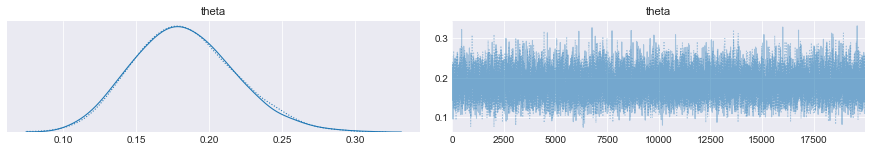

In [11]:
#Jenkins model

y = np.array([Total_eruptions_per_100_year])
n = np.array([100])
N = len(n)

Std_eruptions_per_year = STD_eruptions_per_year
alpha_analogue_jenkins = Average_eruptions_per_year**2 * ((1-Average_eruptions_per_year)/Std_eruptions_per_year**2 -1/Average_eruptions_per_year)
beta_analogue_jenkins = alpha_analogue_jenkins * (1/Average_eruptions_per_year-1)

with pm.Model() as AP_model_GVP:
    theta = pm.Beta('theta', alpha=alpha_analogue_jenkins, beta=beta_analogue_jenkins)
    p = pm.Binomial('y', p=theta, observed=y, n=n)
    trace_AP = pm.sample(20000, tune=10000, chains=2, target_accept=0.99)

pm.traceplot(trace_AP);
Alpha_Beta = pm.summary(trace_AP)
print(Alpha_Beta)

[Text(0, 0.5, 'Density'), Text(0.5, 0, 'Annual probability of eruption')]

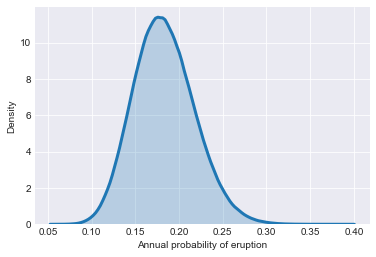

In [12]:
# Visualisation

from scipy.stats import beta

mu = Alpha_Beta['mean'][0]
sigma = Alpha_Beta['sd'][0]
a = mu**2 * ((1-mu)/sigma**2 -1/mu)
b = a * (1/mu-1)
#print(a)
#print(b)

data_beta = beta.rvs(a=a, b=b, size=1000000)
#prior = beta.rvs(a=0.0505, b=0.9595, size=1000000)
ax = sns.distplot(data_beta, 
                  hist = False, 
                  kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3})
ax.set(xlabel='Annual probability of eruption', ylabel='Density')

## Assessing frequency of eruption (any magnitude) using Whelley
We now do the same for the Whellely classification model. Again, no divergence. 

This time, we can see the mean rate of eruptions has centred on 0.16, equivalent to an eruption every 6 years. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]
Sampling 2 chains, 0 divergences: 100%|██████████| 60000/60000 [00:56<00:00, 1053.99draws/s]


        mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
theta  0.163  0.032   0.104    0.223        0.0      0.0   10523.0  10478.0   

       ess_bulk  ess_tail  r_hat  
theta   10435.0    9603.0    1.0  


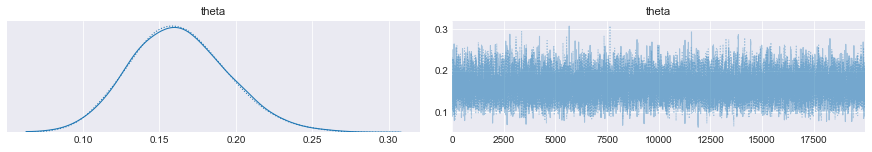

In [13]:
Whelley_Std_eruptions_per_year = Whelley_STD_eruptions_per_year
y = np.array([Total_eruptions_per_100_year])
n = np.array([100])
N = len(n)

alpha_analogue_Whelley = Whelley_Average_eruptions_per_year**2 * ((1-Whelley_Average_eruptions_per_year)/Whelley_Std_eruptions_per_year**2 -1/Whelley_Average_eruptions_per_year)
beta_analogue_Whelley = alpha_analogue_Whelley * (1/Whelley_Average_eruptions_per_year-1)

with pm.Model() as AP_model_Whelley:
    theta_Whelley = pm.Beta('theta', alpha=alpha_analogue_Whelley, beta=beta_analogue_Whelley)
    p_whelley = pm.Binomial('y', p=theta_Whelley, observed=y, n=n)
    trace_AP_Whelley = pm.sample(20000, tune=10000, chains=2, target_accept=0.99)

pm.traceplot(trace_AP_Whelley);
Alpha_Beta_Whelley = pm.summary(trace_AP_Whelley)
print(Alpha_Beta_Whelley)

## Model averaging



In [14]:
##Comparing the models and assigning a weight.
traces = [trace_AP, trace_AP_Whelley]
model_dict = dict(zip([AP_model_GVP, AP_model_Whelley], traces))
comp = pm.compare(model_dict, method='stacking')
comp['index'] = [0, 1]
comp.set_index("index", inplace = True) 
comp

C:\Users\hayes.jlee\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\stats\stats.py:532: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
C:\Users\hayes.jlee\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\stats\stats.py:562: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  "The point-wise LOO is the same with the sum LOO, please double check "
C:\Users\hayes.jlee\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\stats\stats.py:532: UserWarning: Estimated sha

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
index,,,,,,,,,
0,0,-5.24761,2.32494,0,0.5,0,0,True,log
1,1,-7.41002,4.1142,2.16241,0.5,0,0,True,log


In [15]:
## Combining the models

ppc_ave = pm.sample_posterior_predictive_w(traces, 100000, [AP_model_GVP, AP_model_Whelley],
                        weights=comp.weight.sort_index(ascending=True),
                        progressbar=False)

ppc_Jenkins = pm.sample_posterior_predictive(trace_AP, 100000, AP_model_GVP,
                     progressbar=False)

ppc_Whelley = pm.sample_posterior_predictive(trace_AP_Whelley, 100000, AP_model_Whelley,
                     progressbar=False)

ppc_ave_adjust = ppc_ave['y']/100
ppc_Jenkins_adjust = ppc_Jenkins['y']/100
ppc_Whelley_adjust = ppc_Whelley['y']/100

## Model comparison

Below, the results of the model averaging can be seen in comparison to the original two models. 

[Text(0, 0.5, 'Density'), Text(0.5, 0, 'Annual probability of eruption')]

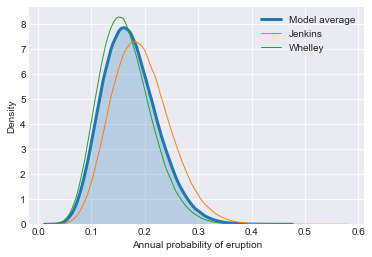

In [16]:
### Visualising the combined models. 

Ave = ppc_ave_adjust.mean()
Std = ppc_ave_adjust.std()

Ave_Jenkins = ppc_Jenkins_adjust.mean()
Std_Jenkins = ppc_Jenkins_adjust.std()
Ave_Whelley = ppc_Whelley_adjust.mean()
Std_Whelley = ppc_Whelley_adjust.std()


a_ave = Ave**2 * ((1-Ave)/Std**2 -1/Ave)
b_ave = a_ave * (1/Ave-1)

a_Jenks = Ave_Jenkins**2 * ((1-Ave_Jenkins)/Std_Jenkins**2 -1/Ave_Jenkins)
b_Jenks = a_ave * (1/Ave_Jenkins-1)
a_Whelley = Ave_Whelley**2 * ((1-Ave_Whelley)/Std_Whelley**2 -1/Ave_Whelley)
b_Whelley = a_ave * (1/Ave_Whelley-1)

data_beta = beta.rvs(a=a_ave, b=b_ave, size=1000000)
data_Jenkins = beta.rvs(a=a_Jenks, b=b_Jenks, size=1000000)
data_Whelley = beta.rvs(a=a_Whelley, b=b_Whelley, size=1000000)


#prior = beta.rvs(a=0.0505, b=0.9595, size=1000000)
ax = sns.distplot(data_beta, 
                  hist = False, 
                  kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3, "label": "Model average"})
ax = sns.distplot(data_Jenkins, 
                  hist = False, 
                  kde = True,
                 kde_kws = {'shade': False, 'linewidth': 1, "label": "Jenkins"})
ax = sns.distplot(data_Whelley, 
                  hist = False, 
                  kde = True,
                 kde_kws = {'shade': False, 'linewidth': 1, "label": "Whelley"})
ax.set(xlabel='Annual probability of eruption', ylabel='Density')

## Assessing relative frequency-magnitude

Here we set up the model to assess the probability of different VEI eruptions, conditional on an eruption occurring. We use a Dirichlet distribution for the prior and a multinomial for the likelihood.  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [01:08<00:00, 435.92draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
parameters[0],0.904,0.003,0.899,0.910,0.0,0.0,17246.0,17246.0,17257.0,13307.0,1.0
parameters[1],0.066,0.002,0.062,0.071,0.0,0.0,17832.0,17735.0,17979.0,13214.0,1.0
parameters[2],0.024,0.002,0.021,0.027,0.0,0.0,17053.0,16900.0,17141.0,12900.0,1.0
parameters[3],0.005,0.001,0.004,0.006,0.0,0.0,18252.0,18121.0,18089.0,12466.0,1.0
parameters[4],0.001,0.000,0.000,0.001,0.0,0.0,18992.0,17173.0,17776.0,10564.0,1.0


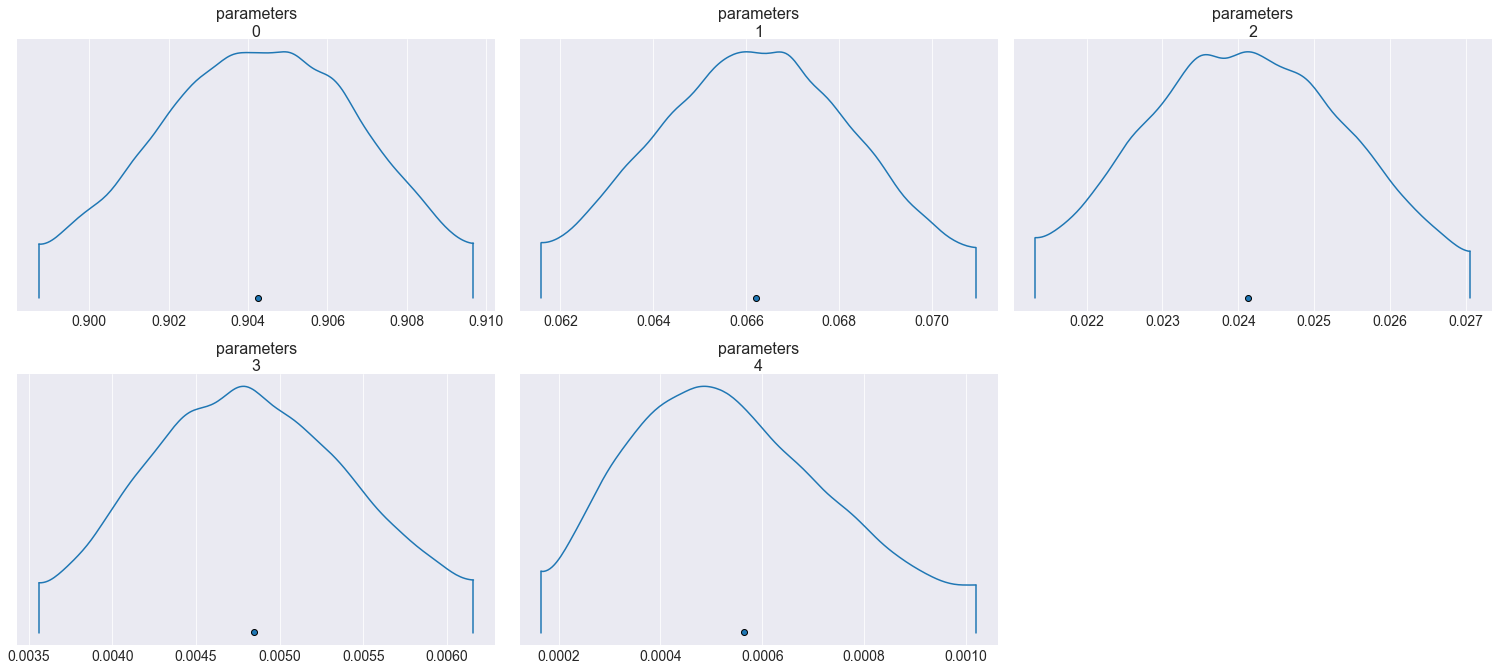

In [17]:
# Jenkins F-M model

Jenkins_1 = np.array([Jenkins_Frequency_VEI_3*10000,
                     Jenkins_Frequency_VEI_4*10000,
                     Jenkins_Frequency_VEI_5*10000,
                     Jenkins_Frequency_VEI_6*10000,
                     Jenkins_Frequency_VEI_7*10000])

Jenkins_2 = np.array([Jenkins_Frequency_VEI_3*10000,
                     Jenkins_Frequency_VEI_4*10000,
                     Jenkins_Frequency_VEI_5*10000,
                     Jenkins_Frequency_VEI_5*10000*0.1,
                     Jenkins_Frequency_VEI_5*10000*0.01])

Jenkins_3 = np.array([Jenkins_Frequency_VEI_3*10000,
                     Jenkins_Frequency_VEI_4*10000,
                     Jenkins_Frequency_VEI_4*10000*0.1,
                     Jenkins_Frequency_VEI_4*10000*0.01,
                     Jenkins_Frequency_VEI_4*10000*0.001])

if Jenkins_Frequency_VEI_7 > 0:
    Jenkins_c = Jenkins_1
elif Jenkins_Frequency_VEI_5 > 0 and Jenkins_Frequency_VEI_7 == 0:
    Jenkins_c = Jenkins_2
elif Jenkins_Frequency_VEI_5 == 0 and Jenkins_Frequency_VEI_7 == 0:
    Jenkins_c = Jenkins_3

Jenkins_shape = Jenkins_c.size

Observed_1 = np.array([Number_VEI_3_or_less_eruptions, 
                     Number_VEI_4_eruptions, 
                     Number_VEI_5_eruptions, 
                     Number_VEI_6_eruptions, 
                     Number_VEI_7_eruptions])

Observed = Observed_1
Observed_sum = np.sum(Observed)

# Create model
with pm.Model() as VEI_model_GVP:
    parameters = pm.Dirichlet('parameters', a=Jenkins_c, shape=Jenkins_shape)
    # Observed data is from a Multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=Observed_sum, p=parameters, shape=Jenkins_shape, observed=Observed)    
    
with VEI_model_GVP:
    # Sample from the posterior
    trace_VEI_GVP = pm.sample(draws=10000, chains=2, tune=5000,
                      discard_tuned_samples=True, target_accept=0.99)


pm.densityplot(trace_VEI_GVP)
pm.summary(trace_VEI_GVP)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [00:37<00:00, 802.41draws/s] 


parameters_stickbreaking__    3.74
observed_data                -2.12
Name: Log-probability of test_point, dtype: float64

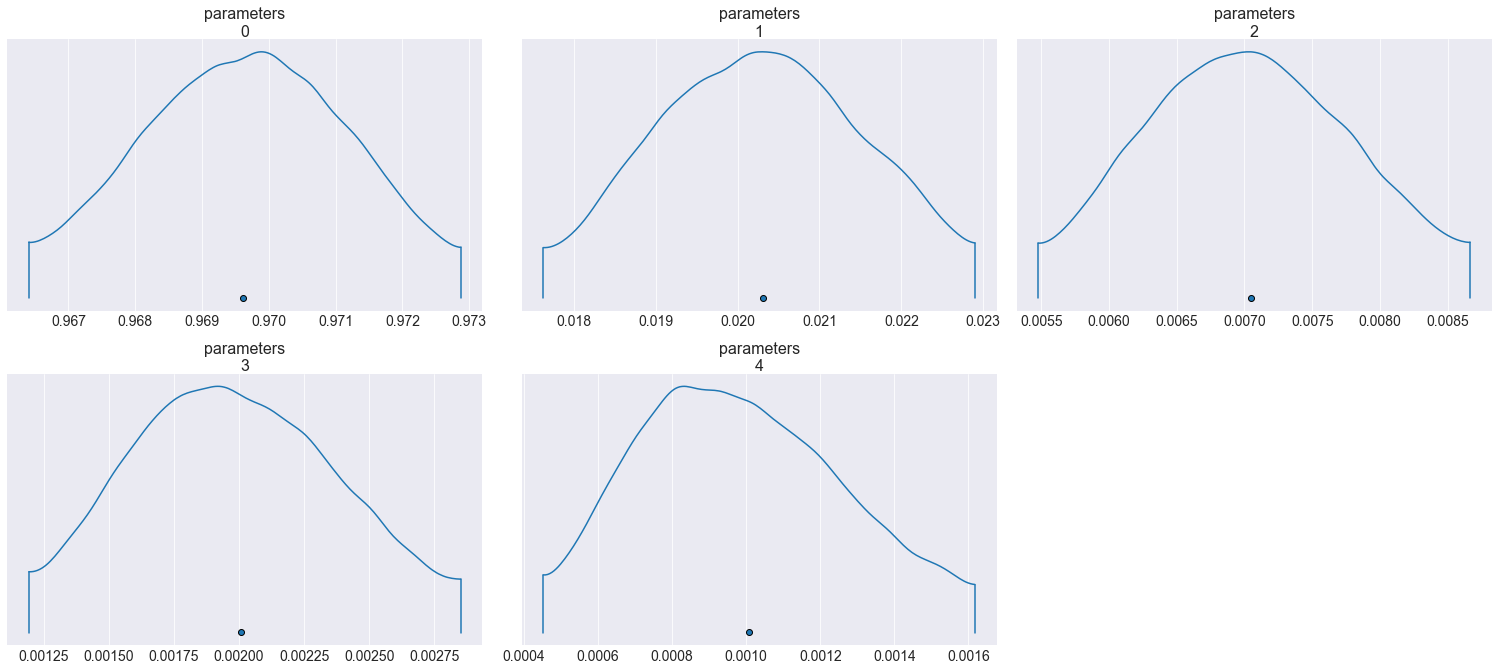

In [18]:
## Whelley model

Whelley_1 = np.array([Whelley_Frequency_VEI_3*10000,
                     Whelley_Frequency_VEI_4*10000,
                     Whelley_Frequency_VEI_5*10000,
                     Whelley_Frequency_VEI_6*10000,
                     Whelley_Frequency_VEI_7*10000])

Whelley_2 = np.array([Whelley_Frequency_VEI_3*10000,
                     Whelley_Frequency_VEI_4*10000,
                     Whelley_Frequency_VEI_5*10000,
                     Whelley_Frequency_VEI_5*10000*0.1,
                     Whelley_Frequency_VEI_5*10000*0.01])

Whelley_3 = np.array([Whelley_Frequency_VEI_3*10000,
                     Whelley_Frequency_VEI_4*10000,
                     Whelley_Frequency_VEI_4*10000*0.1,
                     Whelley_Frequency_VEI_4*10000*0.01,
                     Whelley_Frequency_VEI_4*10000*0.001])

if Whelley_Frequency_VEI_7 > 0:
    Whelley_c = Whelley_1
elif Whelley_Frequency_VEI_5 > 0 and Whelley_Frequency_VEI_7 == 0:
    Whelley_c = Whelley_2
elif Whelley_Frequency_VEI_5 == 0 and Whelley_Frequency_VEI_7 == 0:
    Whelley_c = Whelley_3

Whelley_shape = Whelley_c.size

Observed_1 = np.array([Number_VEI_3_or_less_eruptions, 
                     Number_VEI_4_eruptions, 
                     Number_VEI_5_eruptions, 
                     Number_VEI_6_eruptions, 
                     Number_VEI_7_eruptions])

Observed_2 = np.array([Number_VEI_3_or_less_eruptions, 
                     Number_VEI_4_eruptions, 
                     Number_VEI_5_eruptions])

Observed_3 = np.array([Number_VEI_3_or_less_eruptions, 
                     Number_VEI_4_eruptions])

if Whelley_Frequency_VEI_7 > 0:
    Observed = Observed_1
elif Whelley_Frequency_VEI_5 > 0 and Whelley_Frequency_VEI_7 == 0:
    Observed = Observed_2
elif Whelley_Frequency_VEI_5 == 0 and Whelley_Frequency_VEI_7 == 0:
    Observed = Observed_3


Observed_sum = np.sum(Observed)

# Create model
with pm.Model() as VEI_model_Whelley:
    parameters = pm.Dirichlet('parameters', a=Whelley_c, shape=Whelley_shape)
    # Observed data is from a Multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=Observed_sum, p=parameters, shape=Whelley_shape, observed=Observed)    
    
with VEI_model_Whelley:
    # Sample from the posterior
    trace_VEI_Whelley = pm.sample(draws=10000, chains=2, tune=5000,
                      discard_tuned_samples=True)

pm.densityplot(trace_VEI_Whelley)
pm.summary(trace_VEI_Whelley)

## Model comparison and average
We run the same model comparison and averaging as previously.

In [19]:
## Comparing the models 

traces_VEI = [trace_VEI_GVP, trace_VEI_Whelley]
model_dict_VEI = dict(zip([VEI_model_GVP, VEI_model_Whelley], traces_VEI))
comp_VEI = pm.compare(model_dict_VEI, method='stacking')
comp_VEI['index'] = [0, 1]
comp_VEI.set_index("index", inplace = True) 
#comp_VEI

C:\Users\hayes.jlee\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\stats\stats.py:562: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  "The point-wise LOO is the same with the sum LOO, please double check "
C:\Users\hayes.jlee\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\stats\stats.py:562: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  "The point-wise LOO is the same with the sum LOO, please double check "


In [20]:
## Combining the models based on the weighting

ppc_ave_VEI = pm.sample_posterior_predictive_w(traces_VEI, 1000, [VEI_model_GVP, VEI_model_Whelley],
                        weights=comp.weight.sort_index(ascending=True),
                        progressbar=False)

In [26]:
#Converting the combined model output into a proportions for each VEI

try:
    ppc_ave_VEI_df = pd.DataFrame(ppc_ave_VEI)
    ppc_ave_VEI_df2 = pd.DataFrame(ppc_ave_VEI_df['observed_data'].to_list(), columns=['VEI3', 'VEI4', 'VEI5', 'VEI6', 'VEI7'])
    ppc_ave_VEI_df2 = ppc_ave_VEI_df2.fillna(0)
except ValueError:
    ppc_ave_VEI_df = pd.DataFrame(ppc_ave_VEI['observed_data'])
    ppc_ave_VEI_df2 = ppc_ave_VEI_df
    ppc_ave_VEI_df2.columns = ['VEI3', 'VEI4', 'VEI5', 'VEI6', 'VEI7'] 


if Whelley_Frequency_VEI_5 > 0 and Whelley_Frequency_VEI_7 == 0:
    ppc_ave_VEI_df2 = ppc_ave_VEI_df.fillna(0)
elif Whelley_Frequency_VEI_5 == 0 and Whelley_Frequency_VEI_7 == 0:
    ppc_ave_VEI_df2 = ppc_ave_VEI_df.fillna(0)
elif Jenkins_Frequency_VEI_5 == 0 and Whelley_Frequency_VEI_7 == 0:
    ppc_ave_VEI_df2 = ppc_ave_VEI_df.fillna(0)
if Whelley_Frequency_VEI_5 > 0 and Whelley_Frequency_VEI_7 == 0:
    ppc_ave_VEI_df2 = ppc_ave_VEI_df.fillna(0)
else:
    ppc_ave_VEI_df2 = ppc_ave_VEI_df

ppc_ave_VEI_df2['total'] = ppc_ave_VEI_df2['VEI3']+ppc_ave_VEI_df2['VEI4']+ppc_ave_VEI_df2['VEI5']+ppc_ave_VEI_df2['VEI6']+ppc_ave_VEI_df2['VEI7']
ppc_ave_VEI_df2['pVEI3'] = ppc_ave_VEI_df2['VEI3']/ppc_ave_VEI_df2['total']
ppc_ave_VEI_df2['pVEI4'] = ppc_ave_VEI_df2['VEI4']/ppc_ave_VEI_df2['total']
ppc_ave_VEI_df2['pVEI5'] = ppc_ave_VEI_df2['VEI5']/ppc_ave_VEI_df2['total']
ppc_ave_VEI_df2['pVEI6'] = ppc_ave_VEI_df2['VEI6']/ppc_ave_VEI_df2['total']
ppc_ave_VEI_df2['pVEI7'] = ppc_ave_VEI_df2['VEI7']/ppc_ave_VEI_df2['total']


In [27]:
#Obtain the mean, standard deviation of the combined model and obtain the beta distribution parameters. 

VEI_3_mean = ppc_ave_VEI_df2['pVEI3'].mean()
VEI_3_sd = ppc_ave_VEI_df2['pVEI3'].std()

VEI_4_mean = ppc_ave_VEI_df2['pVEI4'].mean()
VEI_4_sd = ppc_ave_VEI_df2['pVEI4'].std()

VEI_5_mean = ppc_ave_VEI_df2['pVEI5'].mean()
VEI_5_sd = ppc_ave_VEI_df2['pVEI5'].std()

VEI_6_mean = ppc_ave_VEI_df2['pVEI6'].mean()
VEI_6_sd = ppc_ave_VEI_df2['pVEI6'].std()

VEI_7_mean = ppc_ave_VEI_df2['pVEI7'].mean()
VEI_7_sd = ppc_ave_VEI_df2['pVEI7'].std()

a_ave_VEI3 = VEI_3_mean**2 * ((1-VEI_3_mean)/VEI_3_sd**2 -1/VEI_3_mean)
b_ave_VEI3 = a_ave_VEI3 * (1/VEI_3_mean-1)

a_ave_VEI4 = VEI_4_mean**2 * ((1-VEI_4_mean)/VEI_4_sd**2 -1/VEI_4_mean)
b_ave_VEI4 = a_ave_VEI4 * (1/VEI_4_mean-1)

a_ave_VEI5 = VEI_5_mean**2 * ((1-VEI_5_mean)/VEI_5_sd**2 -1/VEI_5_mean)
b_ave_VEI5 = a_ave_VEI5 * (1/VEI_5_mean-1)

a_ave_VEI6 = VEI_6_mean**2 * ((1-VEI_6_mean)/VEI_6_sd**2 -1/VEI_6_mean)
b_ave_VEI6 = a_ave_VEI6 * (1/VEI_6_mean-1)

a_ave_VEI7 = VEI_7_mean**2 * ((1-VEI_7_mean)/VEI_7_sd**2 -1/VEI_7_mean)
b_ave_VEI7 = a_ave_VEI7 * (1/VEI_7_mean-1)

data_beta_VEI3 = beta.rvs(a=a_ave_VEI3, b=b_ave_VEI3, size=1000000)
data_beta_VEI4 = beta.rvs(a=a_ave_VEI4, b=b_ave_VEI4, size=1000000)
data_beta_VEI5 = beta.rvs(a=a_ave_VEI5, b=b_ave_VEI5, size=1000000)
data_beta_VEI6 = beta.rvs(a=a_ave_VEI6, b=b_ave_VEI6, size=1000000)
data_beta_VEI7 = beta.rvs(a=a_ave_VEI7, b=b_ave_VEI7, size=1000000)

In [28]:
## Combining probability of eruption and relative probability of different VEI

import scipy.stats as stats

AP_VEI_3 = []
Number = 10000
lower, upper = 0, 1
for i in range(Number):
    """Monte Carlo simulation"""
    AP_VEI3 = (np.random.beta(a_ave, b_ave) * stats.truncnorm.rvs((lower - VEI_3_mean) / VEI_3_sd, (upper - VEI_3_mean) / VEI_3_sd, loc=VEI_3_mean, scale=VEI_3_sd))
    AP_VEI_3 = AP_VEI_3+[AP_VEI3]

AP_VEI_4 = []
Number = 10000
lower, upper = 0, 1
for i in range(Number):
    """Monte Carlo simulation"""
    AP_VEI4 = (np.random.beta(a_ave, b_ave) * stats.truncnorm.rvs((lower - VEI_4_mean) / VEI_4_sd, (upper - VEI_4_mean) / VEI_4_sd, loc=VEI_4_mean, scale=VEI_4_sd))
    AP_VEI_4 = AP_VEI_4+[AP_VEI4]

AP_VEI_5 = []
Number = 10000
lower, upper = 0, 1
for i in range(Number):
    """Monte Carlo simulation"""
    AP_VEI5 = (np.random.beta(a_ave, b_ave) * stats.truncnorm.rvs((lower - VEI_5_mean) / VEI_5_sd, (upper - VEI_5_mean) / VEI_5_sd, loc=VEI_5_mean, scale=VEI_5_sd))
    AP_VEI_5 = AP_VEI_5+[AP_VEI5]
    
AP_VEI_6 = []
Number = 10000
lower, upper = 0, 1
for i in range(Number):
    """Monte Carlo simulation"""
    AP_VEI6 = (np.random.beta(a_ave, b_ave) * stats.truncnorm.rvs((lower - VEI_6_mean) / VEI_6_sd, (upper - VEI_6_mean) / VEI_6_sd, loc=VEI_6_mean, scale=VEI_6_sd))
    AP_VEI_6 = AP_VEI_6+[AP_VEI6]
    
AP_VEI_7 = []
Number = 10000
lower, upper = 0, 1
for i in range(Number):
    """Monte Carlo simulation"""
    AP_VEI7 = (np.random.beta(a_ave, b_ave) * stats.truncnorm.rvs((lower - VEI_7_mean) / VEI_7_sd, (upper - VEI_7_mean) / VEI_7_sd, loc=VEI_7_mean, scale=VEI_7_sd))
    AP_VEI_7 = AP_VEI_7+[AP_VEI7]
    


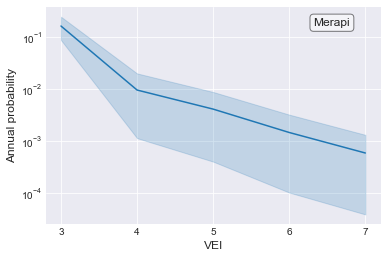

In [29]:
##Visualisation of median, 5th, and 95th percentile.

VEI_3_Median = stats.scoreatpercentile(AP_VEI_3, 50)
VEI_3_Percentile_05 = stats.scoreatpercentile(AP_VEI_3, 5)
VEI_3_Percentile_95 = stats.scoreatpercentile(AP_VEI_3, 95)

VEI_4_Median = stats.scoreatpercentile(AP_VEI_4, 50)
VEI_4_Percentile_05 = stats.scoreatpercentile(AP_VEI_4, 5)
VEI_4_Percentile_95 = stats.scoreatpercentile(AP_VEI_4, 95)

VEI_5_Median = stats.scoreatpercentile(AP_VEI_5, 50)
VEI_5_Percentile_05 = stats.scoreatpercentile(AP_VEI_5, 5)
VEI_5_Percentile_95 = stats.scoreatpercentile(AP_VEI_5, 95)

VEI_6_Median = stats.scoreatpercentile(AP_VEI_6, 50)
VEI_6_Percentile_05 = stats.scoreatpercentile(AP_VEI_6, 5)
VEI_6_Percentile_95 = stats.scoreatpercentile(AP_VEI_6, 95)

VEI_7_Median = stats.scoreatpercentile(AP_VEI_7, 50)
VEI_7_Percentile_05 = stats.scoreatpercentile(AP_VEI_7, 5)
VEI_7_Percentile_95 = stats.scoreatpercentile(AP_VEI_7, 95)

Median = "50th percentile"
Percentile_05 = "5th percentile"
Percentile_95 = "95th percentile"

Percentile_05s = [[3, 4, 5, 6, 7], [VEI_3_Percentile_05, VEI_4_Percentile_05, VEI_5_Percentile_05, VEI_6_Percentile_05, VEI_7_Percentile_05]]
Percentile_95s = [[3, 4, 5, 6, 7], [VEI_3_Percentile_95, VEI_4_Percentile_95, VEI_5_Percentile_95, VEI_6_Percentile_95, VEI_7_Percentile_95]]

Probabilities = pd.DataFrame([[3, VEI_3_Median], 
                        [4, VEI_4_Median], 
                        [5, VEI_5_Median], 
                        [6, VEI_6_Median], 
                        [7, VEI_7_Median],
                        [3, VEI_3_Percentile_05], 
                        [4, VEI_4_Percentile_05], 
                        [5, VEI_5_Percentile_05], 
                        [6, VEI_6_Percentile_05], 
                        [7, VEI_7_Percentile_05],
                        [3, VEI_3_Percentile_95], 
                        [4, VEI_4_Percentile_95], 
                        [5, VEI_5_Percentile_95], 
                        [6, VEI_6_Percentile_95], 
                        [7, VEI_7_Percentile_95]], 
                       columns=["VEI", "Annual probability"])

ax = sns.lineplot(x="VEI", y="Annual probability", markers=True, data=Probabilities)
ax.set(yscale="log")
ax.set_xticks(range(3, 8)) # <--- set the ticks first
ax.tick_params(labelsize=10)
ax.set_xticklabels(['3','4','5','6','7'])
ax.set_xlabel("VEI",fontsize=12)
ax.set_ylabel("Annual probability",fontsize=12)

Volcano_name = Volcano_name
textstr = Volcano_name

Probabilities_df = pd.DataFrame([[Volcano_name, VEI_3_Percentile_05, VEI_3_Median, VEI_3_Percentile_95, 
                                    VEI_4_Percentile_05, VEI_4_Median, VEI_4_Percentile_95, 
                                    VEI_5_Percentile_05, VEI_5_Median, VEI_5_Percentile_95, 
                                    VEI_6_Percentile_05, VEI_6_Median, VEI_6_Percentile_95, 
                                    VEI_7_Percentile_05, VEI_7_Median, VEI_7_Percentile_95]], 
                                  columns=["Volcano Name",
                                          "<= VEI 3 5th percentile",
                                          "<= VEI 3 50th percentile",
                                          "<= VEI 3 95th percentile", 
                                           "VEI 4 5th percentile",
                                          "VEI 4 50th percentile",
                                          "VEI 4 95th percentile",
                                          "VEI 5 5th percentile",
                                          "VEI 5 50th percentile",
                                          "VEI 5 95th percentile",
                                          "VEI 6 5th percentile",
                                          "VEI 6 50th percentile",
                                          "VEI 6 95th percentile",
                                          "VEI 7 5th percentile",
                                          "VEI 7 50th percentile",
                                          "VEI 7 95th percentile"])

path_csv = "Probabilities/" + Volcano_name + ".csv"
Probabilities_df.to_csv(path_csv)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.80, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)


ax.plot()
path_fig = "Figures/" + Volcano_name + ".png"
plt.savefig(path_fig)

## References

Jenkins S, Magill C, McAneney J, Blong R (2012) Regional ash fall hazard I: a probabilistic assessment methodology. Bulletin of Volcanology 74:1699-1712. https://doi.org/10.1007/s00445-012-0627-8

Jenkins SF, Magill C, McAneney J, Blong R (2018) Evaluating relative tephra fall hazard and risk in the Asia-Pacific region. Geosphere 14(2):492-509. https://doi.org/10.1130/GES01549.1

Loughlin SC, Sparks S, Brown SK, Jenkins SF, Vye-Brown C (2015) Global Volcanic Hazards and Risk. Cambridge University Press.  https://doi.org/10.1017/CBO9781316276273

Mead S, Magill C (2014) Determining change points in data completeness for the Holocene eruption record. Bulletin of Volcanology 76:874. https://doi.org/10.1007/s00445-014-0874-y

Newhall CG, Self S (1982) The volcanic explosivity index (VEI) an estimate of explosive magnitude for historical volcanism. Journal of Geophysical Research 87(c2):1231-1238. https://doi.org/10.1029/JC087iC02p01231

Salvatier J, Wiecki TV, Fonnesbeck C (2016) Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55. https://doi.org/10.7717/peerj-cs.55.

Sheldrake T (2014) Long-term forecasting of eruption hazards: A hierarchical approach to merge analogous eruptive histories. Journal of Volcanology and Geothermal Research 286:15-23. http://doi.org/10.1016/j.jvolgeores.2014.08.021

Sheldrake T, Caricchi L (2017) Regional variability in the frequency and magnitude of large explosive volcanic eruptions. Geology 45(2):111-114. https://doi.org/10.1130/G38372.1

Simkin T, Siebert L (1994) Volcanoes of the world. Geoscience Press, Tucson.

Whelley PL, Newhall CG, Bradley KE (2015) The frequency of explosive volcanic eruptions in Southeast Asia. Bulletin of Volcanology 77:1. https://doi.org/10.1007/s00445-014-0893-8